In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
all_data = pd.read_csv('all_data.csv', index_col=0)
PM25 = pd.read_csv('PM25.csv', index_col=0)
model_data = all_data = pd.concat([all_data, PM25], axis=1)
model_data = model_data.rename(columns={model_data.columns[-1]: "PM2.5"})
model_data = model_data.dropna(subset=["PM2.5"])
model_data

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)

In [5]:
import optuna
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective(trial):
    X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
    y = model_data["PM2.5"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)

    alpha = trial.suggest_float('alpha', 0.01, 1.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')

improvement_threshold = 0.001
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 11000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Najlepsze parametry:", best_params)
print("Najlepszy R^2 Score:", best_r2)


[I 2023-10-22 19:02:53,449] A new study created in memory with name: no-name-aef25755-b8e0-4539-ae48-f44e6941ac81


[I 2023-10-22 19:02:53,485] Trial 0 finished with value: 0.8212441819763645 and parameters: {'alpha': 0.33043892589082063, 'l1_ratio': 0.24952627478689568}. Best is trial 0 with value: 0.8212441819763645.
[I 2023-10-22 19:02:53,494] Trial 1 finished with value: 0.7749403620631359 and parameters: {'alpha': 0.8391920646459488, 'l1_ratio': 0.0930845914208162}. Best is trial 0 with value: 0.8212441819763645.
[I 2023-10-22 19:02:53,502] Trial 2 finished with value: 0.8224161447572471 and parameters: {'alpha': 0.11745305086658146, 'l1_ratio': 0.9367450605258675}. Best is trial 2 with value: 0.8224161447572471.
[I 2023-10-22 19:02:53,514] Trial 3 finished with value: 0.8258663177370602 and parameters: {'alpha': 0.4930984275436339, 'l1_ratio': 0.9277084390269439}. Best is trial 3 with value: 0.8258663177370602.
[I 2023-10-22 19:02:53,523] Trial 4 finished with value: 0.8213627018717361 and parameters: {'alpha': 0.05521752476335013, 'l1_ratio': 0.9247961394324916}. Best is trial 3 with value: 0

Najlepsze parametry: {'alpha': 0.1181185550686449, 'l1_ratio': 0.01022189705425752}
Najlepszy R^2 Score: 0.8270299314724465


Średni błąd kwadratowy (MSE): 108.96663536057282
Procentowa zgodność: 82.70%


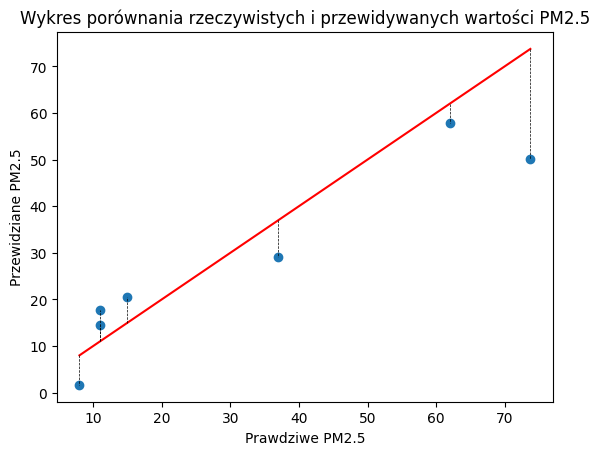

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,11.00,17.672011,-6.672011
1,10.98,14.498594,-3.518594
2,73.73,50.181711,23.548289
3,15.00,20.445185,-5.445185
4,8.00,1.657460,6.342540
5,37.00,29.049212,7.950788
6,62.02,57.747367,4.272633


In [2]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


params =  {'alpha': 0.1181185550686449, 'l1_ratio': 0.01022189705425752}
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data["PM2.5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)


model = ElasticNet(**params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results



